#  Rideshare App Churn Prediction


This casestudy is focused on rider last 30 days retention for a ride-sharing company.

### Label: did a user churn? 
#### Definitions:

A ride-sharing company (Company X) is interested in predicting rider retention.
To help explore this question, a sample dataset of a cohort of users who signed up for an account in January 2014. **The data was pulled on July1, 2014**; A user is considered retained if they were “active” (i.e. took a trip)
in the preceding 30 days (from the day the data was pulled). In other words, a user is "active" if they have taken a trip since June 1, 2014. 

- **1 => CHURN**
    - The User **did not** use the ride sharing service in the last 30 days
- **0 => NO CHURN**
    - The user **did** use the ride sharing service in the last 30 days
    
-----------------

#### Problem Statement and background:


I use this data set to help understand **what factors are
the best predictors for retention**, and offer suggestions to help Company X. 

Here is a detailed description of the data:

- `city`: city this user signed up in phone: primary device for this user
- `signup_date`: date of account registration; in the form `YYYYMMDD`
- `last_trip_date`: the last time this user completed a trip; in the form `YYYYMMDD`
- `avg_dist`: the average distance (in miles) per trip taken in the first 30 days after signup
- `avg_rating_by_driver`: the rider’s average rating over all of their trips 
- `avg_rating_of_driver`: the rider’s average rating of their drivers over all of their trips 
- `surge_pct`: the percent of trips taken with surge multiplier > 1 
- `avg_surge`: The average surge multiplier over all of this user’s trips 
- `trips_in_first_30_days`: the number of trips this user took in the first 30 days after signing up 
- `luxury_car_user`: TRUE if the user took a luxury car in their first 30 days; FALSE otherwise 
- `weekday_pct`: the percent of the user’s trips occurring during a weekday 

# Part I EDA

### Load data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src.function import *

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import datetime
import warnings
warnings.filterwarnings('ignore')

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

In [199]:
train = pd.read_csv('data/churn_train.csv', parse_dates=['last_trip_date','signup_date'] ,infer_datetime_format=True)
test = pd.read_csv('data/churn_test.csv', parse_dates=['last_trip_date','signup_date'], infer_datetime_format=True)

df_train = train.copy()
df_test = test.copy()

In [5]:
df_train.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct
0,6.94,5.0,5.0,1.00,Astapor,2014-05-03,Android,2014-01-12,0.0,0,False,100.0
1,8.06,5.0,5.0,1.00,Astapor,2014-01-26,Android,2014-01-25,0.0,2,True,0.0
2,21.50,4.0,NaN,1.00,Winterfell,2014-05-21,iPhone,2014-01-02,0.0,1,True,100.0
3,9.46,5.0,NaN,2.75,Winterfell,2014-01-10,Android,2014-01-09,100.0,1,False,100.0
4,13.77,5.0,NaN,1.00,Winterfell,2014-05-13,iPhone,2014-01-31,0.0,0,False,100.0


### Make label

Add churn indicator.  Considered to churn if have not taken a trip in the last 30 days.  In practice, you will often have to figure out how to generate a reasonable label to train your dataset.  Is the cutoff of 30 days reasonable?  You may want to test this...  Sometimes, the correct label is even less obvious; your ability to make a sensible (and defensible) decision in these cases is important.

In addition, do you agree with how the data was aggregated?  It would be helpful to look at lagged usage for the previous week, the week before that, and so on.  Also, checking changes in average rating over time could be helpful.

In [6]:
start_date = pd.to_datetime('2014-07-01', format='%Y-%m-%d', infer_datetime_format=True)

In [7]:
start_date = start_date - datetime.timedelta(30,0,0)
start_date

Timestamp('2014-06-01 00:00:00')

In [8]:
def make_label(df):
    df['churn'] = 1
    mask_not_churn = df['last_trip_date'] >= pd.to_datetime('2014-06-01')
    df.loc[mask_not_churn, 'churn'] = 0 
    return df


In [9]:
df_train = make_label(df_train)
df_test = make_label(df_test)

In [10]:
df = df_train.copy()

In [11]:
df.churn.value_counts(1, dropna=False)

1    0.6242
0    0.3758
Name: churn, dtype: float64

In [12]:
df.city.value_counts(1, dropna=False)

Winterfell        0.4655
Astapor           0.3309
King's Landing    0.2036
Name: city, dtype: float64

In [13]:
df.phone.value_counts(1, dropna=False)

iPhone     0.690700
Android    0.301325
NaN        0.007975
Name: phone, dtype: float64

`phone` is already categorical, so we can add another factor level to handle missing values.  Be careful not to over clean data, because you can use useful predictive information.  Note:  we added this step based on analysis of missing values below.

Convert columns with categorical data into categorical type

In [14]:
df.city = df.city.astype("category")
df.phone = df.phone.astype('category')

In [15]:
pd.crosstab(df.phone, df.city)

city,Astapor,King's Landing,Winterfell
phone,,,
Android,4214,2024,5815
iPhone,8924,6066,12638


In [16]:
df.shape

(40000, 13)

In [17]:
df.isnull().sum()

avg_dist                     0
avg_rating_by_driver       162
avg_rating_of_driver      6528
avg_surge                    0
city                         0
last_trip_date               0
phone                      319
signup_date                  0
surge_pct                    0
trips_in_first_30_days       0
luxury_car_user              0
weekday_pct                  0
churn                        0
dtype: int64

In [18]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
avg_dist,40000.0,5.791302,5.708056,0.0,2.42,3.88,6.93,160.96
avg_rating_by_driver,39838.0,4.777434,0.448088,1.0,4.70,5.00,5.00,5.00
avg_rating_of_driver,33472.0,4.601697,0.614810,1.0,4.30,4.90,5.00,5.00
avg_surge,40000.0,1.074956,0.222427,1.0,1.00,1.00,1.05,8.00
surge_pct,40000.0,8.857342,20.014008,0.0,0.00,0.00,8.30,100.00
trips_in_first_30_days,40000.0,2.280700,3.811289,0.0,0.00,1.00,3.00,125.00
weekday_pct,40000.0,60.874382,37.089619,0.0,33.30,66.70,100.00,100.00
churn,40000.0,0.624200,0.484335,0.0,0.00,1.00,1.00,1.00


In [19]:
df.corr()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,churn
avg_dist,1.000000,0.082303,0.036917,-0.079488,-0.102349,-0.135228,0.025824,0.097445,0.093371
avg_rating_by_driver,0.082303,1.000000,0.118703,0.007859,0.018849,-0.039282,0.010300,0.021552,0.027461
avg_rating_of_driver,0.036917,0.118703,1.000000,-0.033829,-0.010436,-0.013720,0.001759,0.013224,0.012902
avg_surge,-0.079488,0.007859,-0.033829,1.000000,0.793842,-0.001829,-0.075544,-0.113054,0.003146
surge_pct,-0.102349,0.018849,-0.010436,0.793842,1.000000,0.004746,-0.103531,-0.147969,-0.011551
trips_in_first_30_days,-0.135228,-0.039282,-0.013720,-0.001829,0.004746,1.000000,0.114741,0.049731,-0.210677
luxury_car_user,0.025824,0.010300,0.001759,-0.075544,-0.103531,0.114741,1.000000,0.033478,-0.206902
weekday_pct,0.097445,0.021552,0.013224,-0.113054,-0.147969,0.049731,0.033478,1.000000,-0.008383
churn,0.093371,0.027461,0.012902,0.003146,-0.011551,-0.210677,-0.206902,-0.008383,1.000000


### Checking dates

There are often problems with dates, so let's perform some simple checks as part of EDA

In [20]:
np.any(df.last_trip_date < df.signup_date)

False

See what distribution of signup dates looks like

In [21]:
df['signup_year'] = df.signup_date.apply(lambda x: x.year)
df['signup_month'] = df.signup_date.apply(lambda x: x.month)
pd.crosstab(df.signup_month, df.signup_year)

signup_year,2014
signup_month,
1,40000


This means we don't need to worry about any customers who joined in the last 30 days.

In [22]:
df.signup_date.describe()

count                   40000
unique                     31
top       2014-01-18 00:00:00
freq                     2393
first     2014-01-01 00:00:00
last      2014-01-31 00:00:00
Name: signup_date, dtype: object

So all of our signup data comes from January. This could affect customer type and retention if there is a selection effect based on `signup_date.`

In [23]:
df['last_year'] = df.last_trip_date.apply(lambda x: x.year)
df['last_month'] = df.last_trip_date.apply(lambda x: x.month)
pd.crosstab(df.last_month, df.last_year)

last_year,2014
last_month,
1,8172
2,3424
3,3626
4,3658
5,6088
6,14595
7,437


Let's take a look at June to see what is going on day by day

In [24]:
dftmp = df[df.last_month == 6]
dftmp['last_day'] = dftmp.last_trip_date.apply(lambda x: x.day)
dftmp.last_day.value_counts()

29    1632
28    1317
30    1127
27     898
22     807
21     681
26     641
14     545
15     524
20     487
25     477
23     448
7      436
8      435
1      397
24     360
19     350
13     345
18     316
12     285
16     254
6      253
17     241
11     231
9      203
5      199
4      199
10     197
2      171
3      139
Name: last_day, dtype: int64

In [25]:
dftmp = df[df.last_month == 7]
dftmp['last_day'] = dftmp.last_trip_date.apply(lambda x: x.day)
dftmp.last_day.value_counts()

1    437
Name: last_day, dtype: int64

It looks like usage stabilizes for a couple months after signup with users try the new product, but then there is a spike in June. We only have data for 2014-07-01 in July.

### Quick visualization

It is always good to visualize data if possible -- i.e., the data set is not too large.  Note:  we plot active users as red and inactive (churn) as blue.

In [30]:
from pandas.tools.plotting import scatter_matrix

In [31]:
core_features = ['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge', 
                 'surge_pct', 'trips_in_first_30_days', 'luxury_car_user', 'weekday_pct']
colors = ['red' if ix else 'blue' for ix in df.churn]

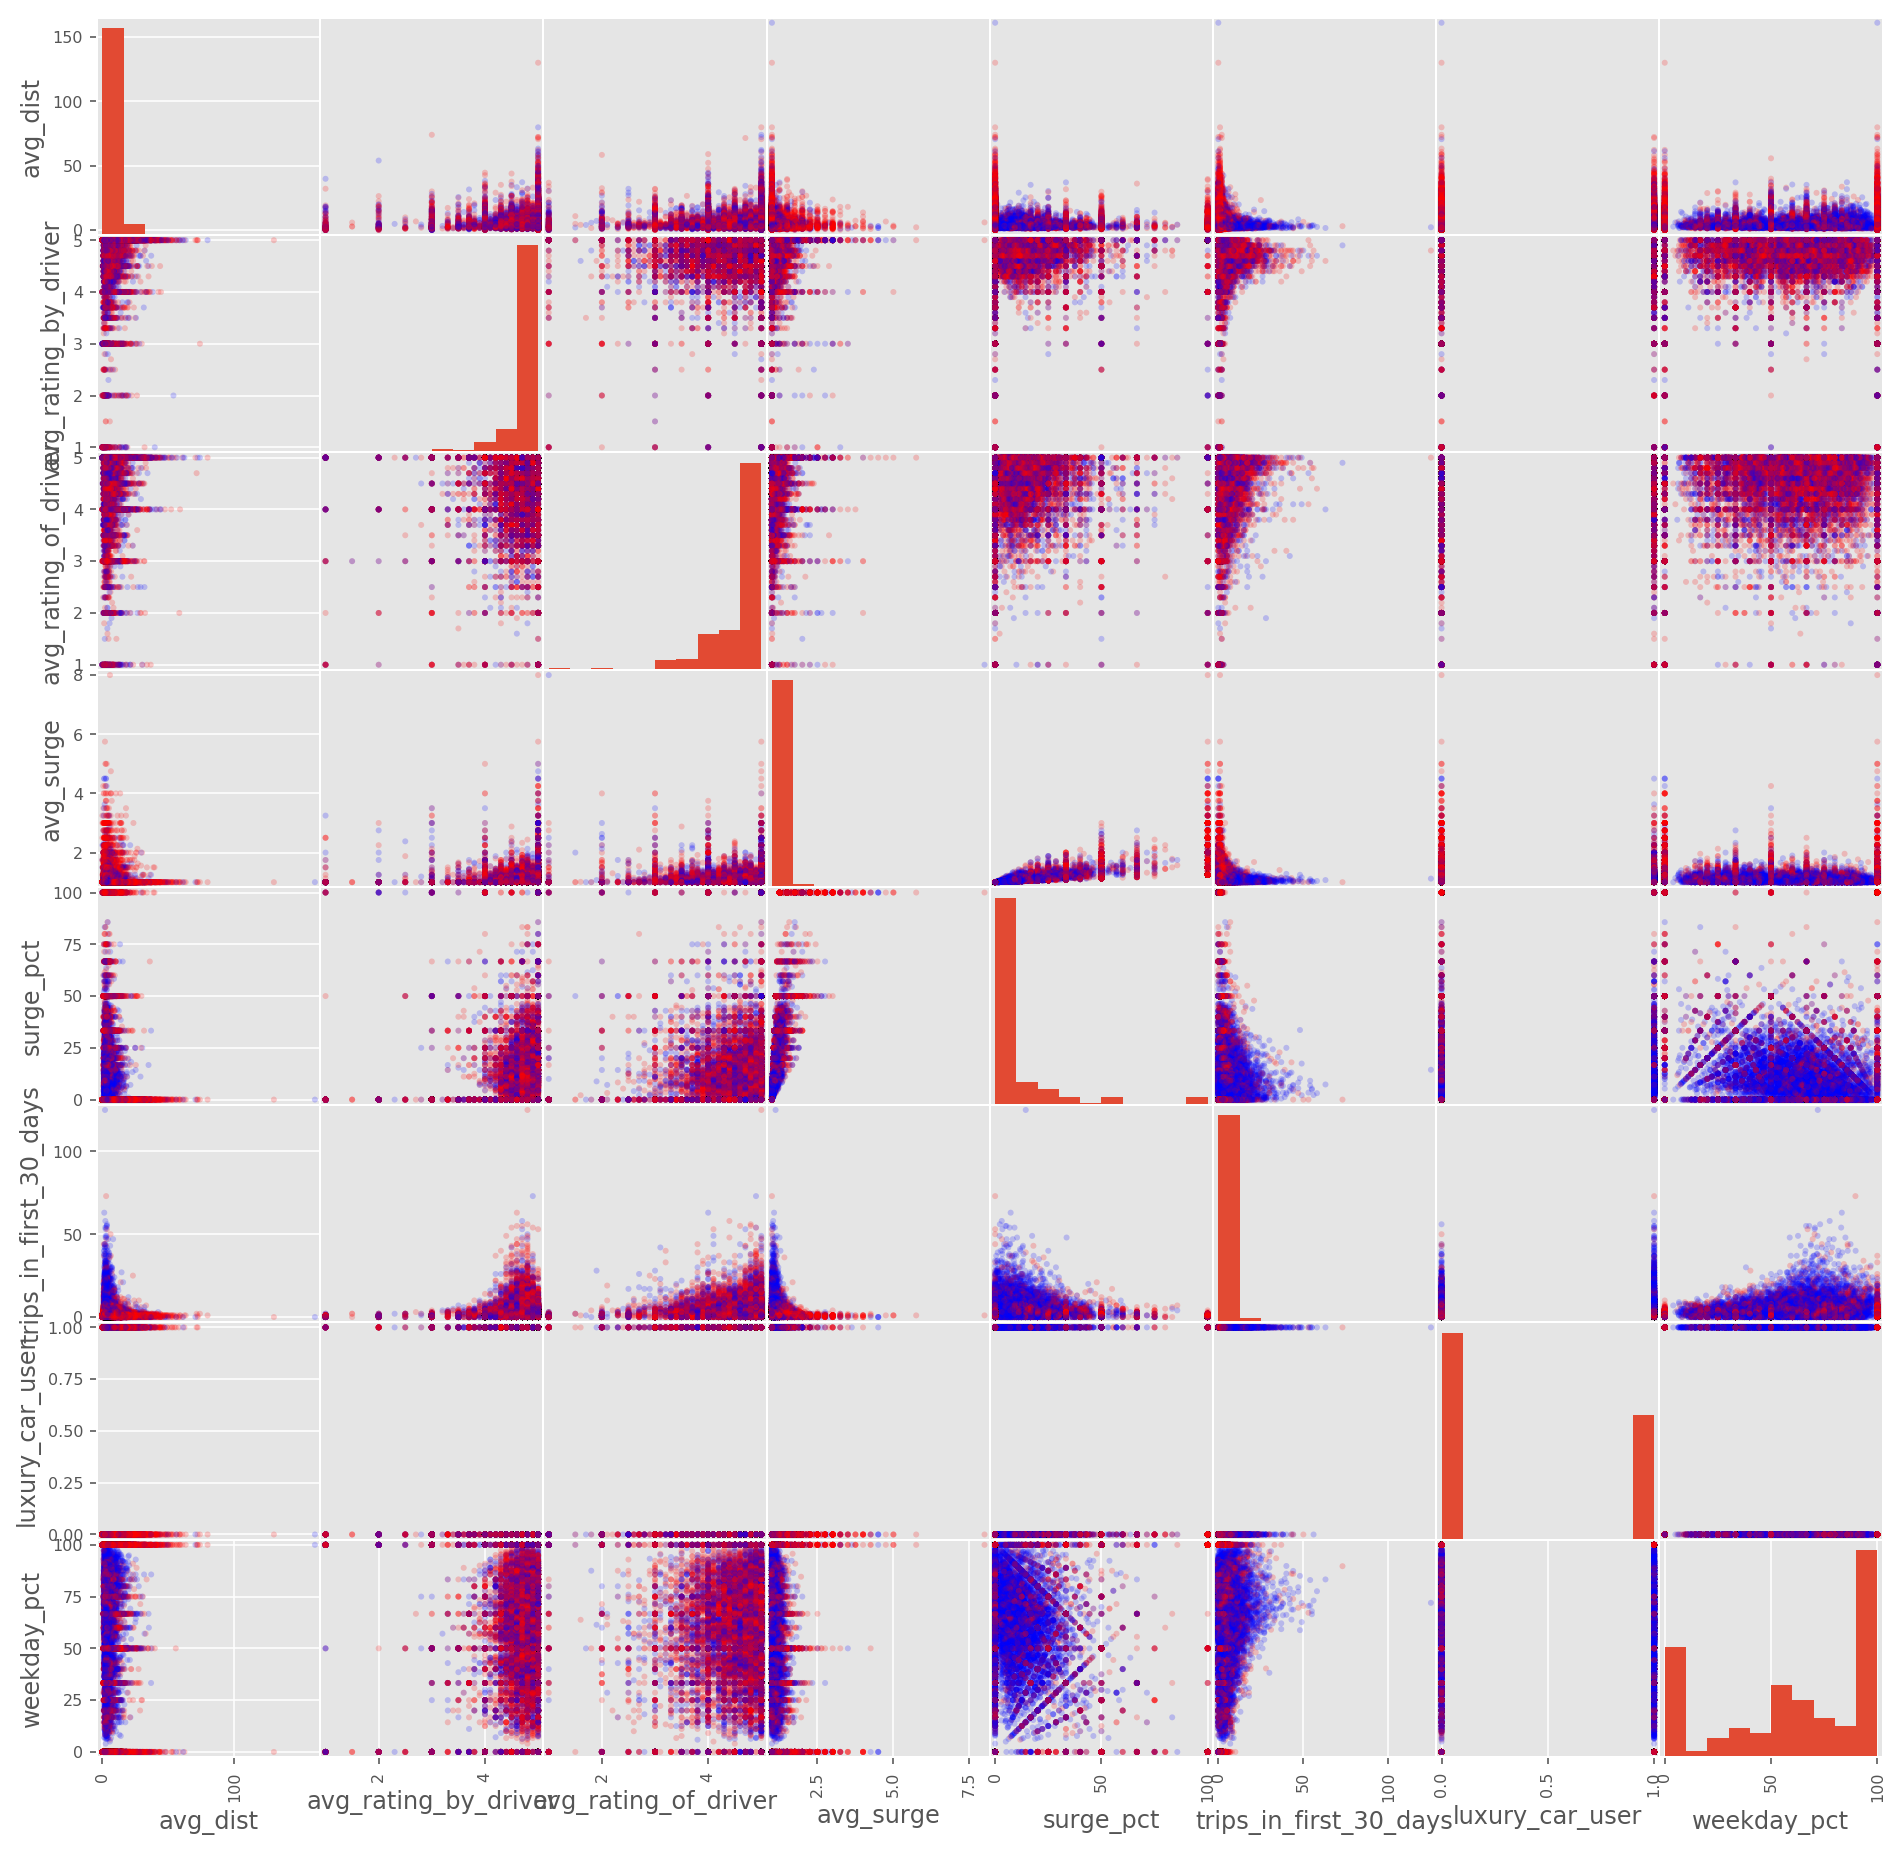

In [32]:
scatter_matrix(df[core_features], alpha=0.2, figsize=(16, 16), diagonal='hist', color=colors);

The scatter matrix does not show any feature which will clearly separate out active vs. inactive users. Some features do seem to help. Thus, we probably have a highly non-linear relationship and should consider a random forest or gradient boosted decision tree, which are ensemble versions of a decision tree. With a lot of feature engineering, we might be able to get comparable performance from logistic regression. 

There seems to be some observations where surge_pct = (+/-) weekday_pct. May merit further investigation or signal a data feed/entry problem.

Let's check some simple 'groupby' stats to see how different groups compare:

In [26]:
df.groupby(['churn']).mean()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,signup_year,signup_month,last_year,last_month
churn,,,,,,,,,,,,
0,5.104428,4.761600,4.592168,1.074054,9.155295,3.315527,0.505322,61.275073,2014.0,1.0,2014.0,6.029071
1,6.204835,4.786996,4.608300,1.075499,8.677960,1.657682,0.298382,60.633146,2014.0,1.0,2014.0,2.842438


In [27]:
df.groupby(['churn', 'last_month']).mean()

avg_dist  avg_rating_by_driver  avg_rating_of_driver  \
churn last_month                                                         
0     6           5.130750              4.761780              4.590617   
      7           4.225309              4.755606              4.640995   
1     1           6.836418              4.805842              4.634690   
      2           6.015050              4.783525              4.581294   
      3           5.812562              4.775589              4.591341   
      4           6.003748              4.771683              4.606194   
      5           5.818252              4.779730              4.602160   

                  avg_surge  surge_pct  trips_in_first_30_days  \
churn last_month                                                 
0     6            1.073949   9.125892                3.254608   
      7            1.077551  10.137300                5.350114   
1     1            1.080054   9.045069                1.707660   
      2            1.087570   9.195064                2.098131   
      3            1.086178   8.837341                1.321842   
      4            1.060175   7.535101                1.352925   
      5            1.065442   8.486120                1.726018   

                  luxury_car_user  weekday_pct  signup_year  signup_month  \
churn last_month                                                            
0     6                  0.505310    60.979966       2014.0           1.0   
      7                  0.505721    71.131121       2014.0           1.0   
1     1                  0.285487    60.001640       2014.0           1.0   
      2                  0.302278    60.886098       2014.0           1.0   
      3                  0.314396    57.598042       2014.0           1.0   
      4                  0.316566    61.958037       2014.0           1.0   
      5                  0.293035    62.350197       2014.0           1.0   

                  last_year  
churn last_month             
0     6              2014.0  
      7              2014.0  
1     1              2014.0  
      2              2014.0  
      3              2014.0  
      4              2014.0  
      5              2014.0

Top users appear to take shorter trips on average, take more trips in the first 30 days and uses luxury cars more.

In [28]:
df.groupby(['churn', 'last_month']).quantile(q=0.5)

0.5               avg_dist  avg_rating_by_driver  avg_rating_of_driver  \
churn last_month                                                         
0     6              3.730                   4.8                   4.8   
      7              3.480                   4.8                   4.8   
1     1              4.260                   5.0                   5.0   
      2              3.830                   5.0                   5.0   
      3              3.775                   5.0                   5.0   
      4              4.155                   5.0                   5.0   
      5              4.010                   5.0                   4.9   

0.5               avg_surge  last_year  luxury_car_user  signup_month  \
churn last_month                                                        
0     6                1.00     2014.0              1.0           1.0   
      7                1.04     2014.0              1.0           1.0   
1     1                1.00     2014.0              0.0           1.0   
      2                1.00     2014.0              0.0           1.0   
      3                1.00     2014.0              0.0           1.0   
      4                1.00     2014.0              0.0           1.0   
      5                1.00     2014.0              0.0           1.0   

0.5               signup_year  surge_pct  trips_in_first_30_days  weekday_pct  
churn last_month                                                               
0     6                2014.0        0.0                     2.0         63.6  
      7                2014.0        6.9                     3.0         69.2  
1     1                2014.0        0.0                     1.0        100.0  
      2                2014.0        0.0                     1.0         66.7  
      3                2014.0        0.0                     0.0         66.7  
      4                2014.0        0.0                     0.0         66.7  
      5                2014.0        0.0                     1.0         66.7

In [29]:
df.groupby(['churn', 'last_month']).std()

avg_dist  avg_rating_by_driver  avg_rating_of_driver  \
churn last_month                                                         
0     6           4.627351              0.332705              0.543941   
      7           2.954730              0.289173              0.478866   
1     1           7.063589              0.578311              0.678401   
      2           5.991845              0.540279              0.707377   
      3           6.101773              0.478811              0.685457   
      4           5.607912              0.471352              0.622580   
      5           5.582316              0.405577              0.618737   

                  avg_surge  surge_pct  trips_in_first_30_days  \
churn last_month                                                 
0     6            0.164290  15.707765                4.949837   
      7            0.121030  13.579435                7.329630   
1     1            0.308161  26.216706                1.545563   
      2            0.275765  23.037948                2.516265   
      3            0.269373  21.326044                3.146949   
      4            0.175490  18.206090                2.756223   
      5            0.164195  18.295597                3.294010   

                  luxury_car_user  weekday_pct  signup_year  signup_month  \
churn last_month                                                            
0     6                  0.499989    29.754953          0.0           0.0   
      7                  0.500540    18.576612          0.0           0.0   
1     1                  0.451674    46.423717          0.0           0.0   
      2                  0.459312    41.137868          0.0           0.0   
      3                  0.464339    40.534362          0.0           0.0   
      4                  0.465200    37.385779          0.0           0.0   
      5                  0.455192    34.805637          0.0           0.0   

                  last_year  
churn last_month             
0     6                 0.0  
      7                 0.0  
1     1                 0.0  
      2                 0.0  
      3                 0.0  
      4                 0.0  
      5                 0.0

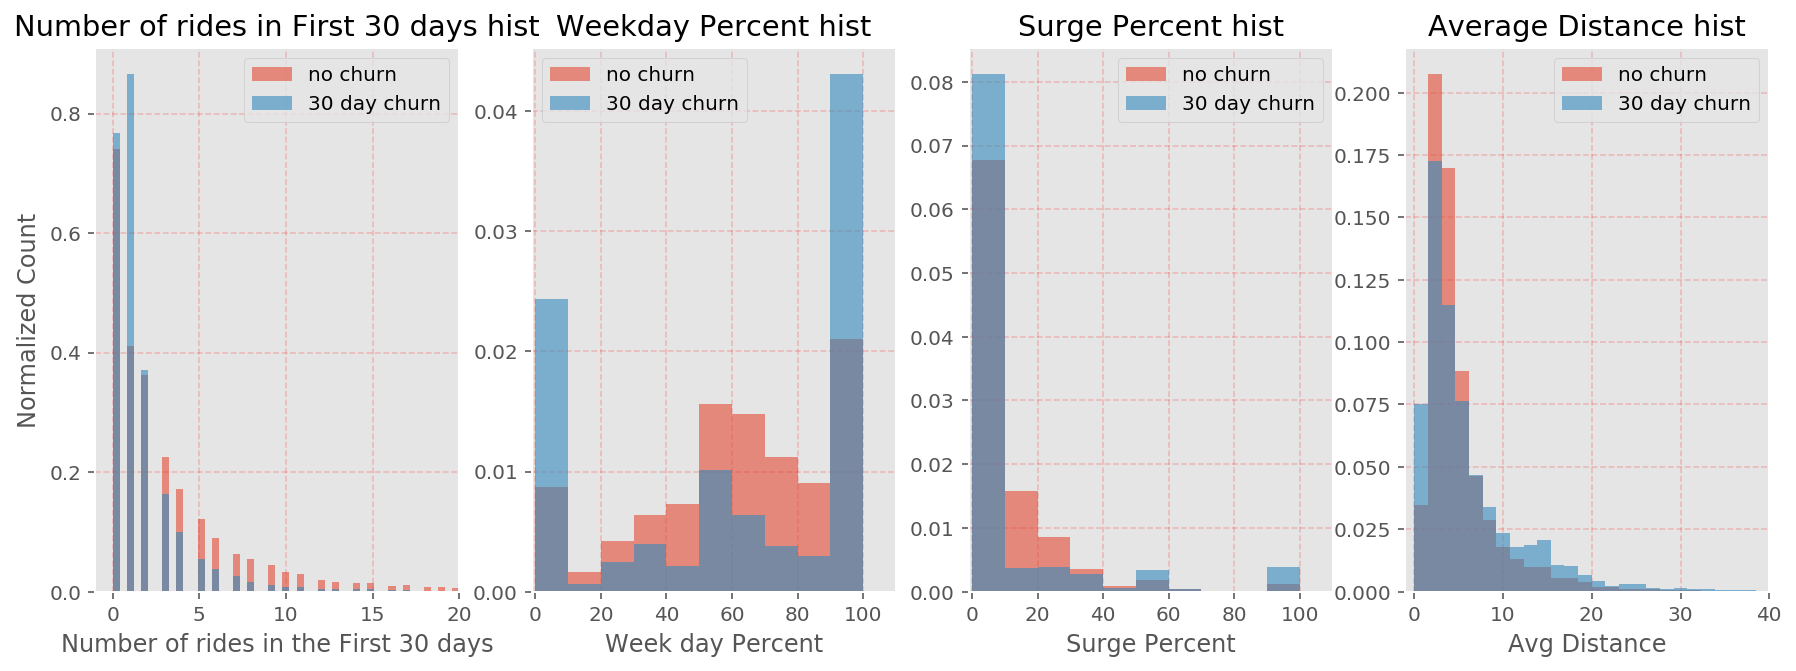

In [34]:
_,ax = plt.subplots(1,4,figsize = (15,5))
plot_(df,df.churn,ax);

It is interesting that the Average distance is such a good split because it is hard to see how there is a difference from this hist.  But looking at the other histograms can give us some insight into our users:
1. Number of rides in the First 30 Days:
    - It appears riders who churn take fewer rides in the first 30 days.  This could be a marketing strategy for the future.  By increases incentives to ride early on, we might be able to minimize the churnover in the longrun
2. Weekday Percent:
    - It appears that riders that ride regularly on the weekdays and the weekends tend to churn over less.  This is also useful as we can use this information to give users who ride exclusively on the weekend or weekdays an incentive to ride more regularly.
3. Surge Percent:
    - It appears that the surge percentage is not a driving users away, and actually possibly the opposite.  Users who have a higher surge appear churn over less up to about 40% surge.  After this, it looks fairly equal although with the higher surge rate, there may be a slightly higher rate of churn.  From this plot, I would not say that the surge pricing is driving away users.

### Missing data

The count field shows some columns have missing data.  Let's look into this and figure out how to deal with it.

In [35]:
df.apply(lambda x: np.sum(pd.isnull(x)))

avg_dist                     0
avg_rating_by_driver       162
avg_rating_of_driver      6528
avg_surge                    0
city                         0
last_trip_date               0
phone                      319
signup_date                  0
surge_pct                    0
trips_in_first_30_days       0
luxury_car_user              0
weekday_pct                  0
churn                        0
signup_year                  0
signup_month                 0
last_year                    0
last_month                   0
dtype: int64

So, ~16% of avg_rating_of_driver is missing, which means we probably should not drop this data. Would be nice to just do a simple t-test to see if distribution of features is different for rows with/without missing values. Here is a helper function:

In [36]:
from scipy import stats as sp
def ttest_by(vals, by):
    '''Compute a t-test on a column based on an indicator for which sample the values are in.'''
    vals1 = vals[by]
    vals2 = vals[-by]
    
    return sp.stats.ttest_ind(vals1, vals2)

In [37]:
ttest_by(df.churn, pd.isnull(df.avg_rating_of_driver))

Ttest_indResult(statistic=31.741611592771839, pvalue=2.1529523725275466e-218)

We can reject H0: of no difference for case where `avg_rating_by_driver` is missing. Thus, `avg_rating_by_driver` is not missing at random. We have a couple options for handling missing data: drop the rows if there are only a few or they are missing at random, impute the missing values, or bin the feature by quantiles (typically deciles) + a bin for missing.

### Rating data

We need to take a closer look at the rating data because most users rate drivers `5`.  MBAs often worry about *mean opinion score* (MOS).  How the app works can affect ratings. E.g., for Uber, if you rate a driver below `4`, you must then explain why.  Consequently, many people don't rate drivers below `4` even if they are horrible.  Be mindful of the incentives which can affect human behavior.

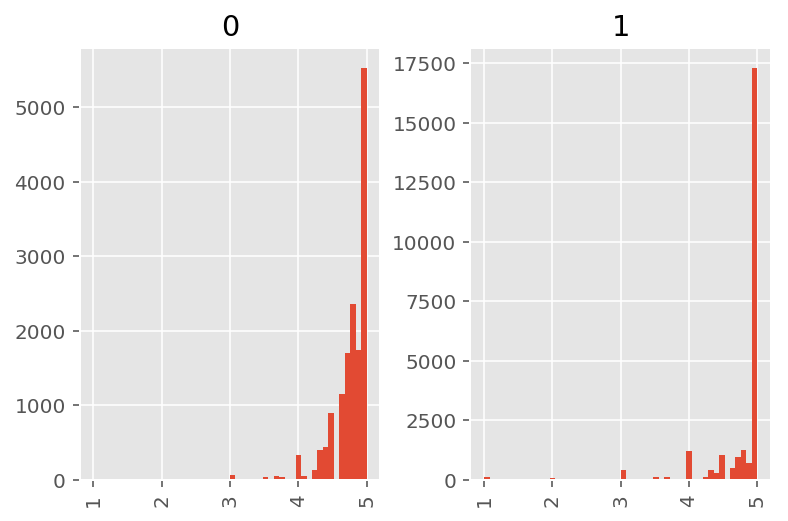

In [38]:
df.avg_rating_by_driver.hist(bins=50, histtype='bar', by=df.churn, stacked=True);

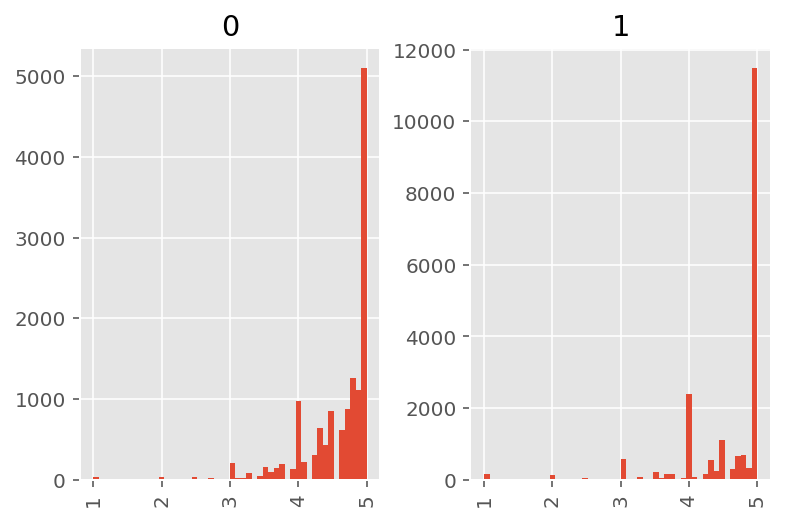

In [39]:
df.avg_rating_of_driver.hist(bins=50, histtype='bar', by=df.churn, stacked=True);

Many users clearly only rate drivers `5` and, conversely, many drivers only rate users `5`.  Note the spike at `4` because many users don't want the hassle of explaining why they rated a driver below `4`.

In [40]:
df['b_rating_5'] = df.avg_rating_of_driver == 5

In [41]:
pd.crosstab(df.b_rating_5, df.churn, dropna=False, margins=True, normalize=True)

churn,0,1,All
b_rating_5,,,
False,0.24835,0.337225,0.585575
True,0.12745,0.286975,0.414425
All,0.37580,0.624200,1.000000


Note: 51% of active users always rate drivers 5 vs. 85% of inactive users. We will worry more about this during feature engineering.

### Missing data: solution

Because a significant fraction of people only give out a rating of `5` and there are disincentives to give a rating below `4`, we choose appropriate cuts below.  If data was distributed more smoothly, we would cut by quantile.  Note that the way we setup the cuts, the top bin contains only ratings whose average is `5`: thus, we do not need the `b_rating_5` field.

In [42]:
df['bin_avg_rating_by_driver'] = pd.cut(df.avg_rating_by_driver, bins=[0., 2.99, 3.99, 4.99, 5], 
                                        right=True)
df['bin_avg_rating_of_driver'] = pd.cut(df.avg_rating_of_driver, bins=[0., 2.99, 3.99, 4.99, 5], 
                                        right=True)

In [43]:
pd.crosstab(df.bin_avg_rating_by_driver, df.b_rating_5)

b_rating_5,False,True
bin_avg_rating_by_driver,,
"(0.0, 2.99]",188,91
"(2.99, 3.99]",586,381
"(3.99, 4.99]",10956,4828
"(4.99, 5.0]",11606,11202


In [44]:
pd.crosstab(df.bin_avg_rating_by_driver, df.churn)

churn,0,1
bin_avg_rating_by_driver,,
"(0.0, 2.99]",36,243
"(2.99, 3.99]",230,737
"(3.99, 4.99]",9211,6573
"(4.99, 5.0]",5523,17285


In [45]:
pd.crosstab(df.bin_avg_rating_of_driver, df.b_rating_5)

b_rating_5,False,True
bin_avg_rating_of_driver,,
"(0.0, 2.99]",553,0
"(2.99, 3.99]",2494,0
"(3.99, 4.99]",13848,0
"(4.99, 5.0]",0,16577


In [46]:
df.bin_avg_rating_by_driver.cat.add_categories('missing', inplace=True)
df.bin_avg_rating_of_driver.cat.add_categories('missing', inplace=True)

In [47]:
df.bin_avg_rating_by_driver.fillna('missing', inplace=True)
df.bin_avg_rating_of_driver.fillna('missing', inplace=True)

In [48]:
pd.crosstab(df.bin_avg_rating_by_driver, df.bin_avg_rating_of_driver)

bin_avg_rating_of_driver,"(0.0, 2.99]","(2.99, 3.99]","(3.99, 4.99]","(4.99, 5.0]",missing
bin_avg_rating_by_driver,,,,,
"(0.0, 2.99]",17,17,35,91,119
"(2.99, 3.99]",41,92,248,381,205
"(3.99, 4.99]",193,1419,8608,4828,736
"(4.99, 5.0]",296,959,4940,11202,5411
missing,6,7,17,75,57


Now these fields are binned with a level for missing. Convert to dummy variables.

In [49]:
df_dum_by = pd.get_dummies(df.bin_avg_rating_by_driver)
df_dum_by.apply(lambda x: x.value_counts())

,"(0.0, 2.99]","(2.99, 3.99]","(3.99, 4.99]","(4.99, 5.0]",missing
0,39721,39033,24216,17192,39838
1,279,967,15784,22808,162


In [50]:
df_dum_by.columns = map(lambda x: 'bin_by_driver_' + str(x), df_dum_by.columns)

In [51]:
df_dum_of = pd.get_dummies(df.bin_avg_rating_of_driver)
df_dum_of.apply(lambda x: x.value_counts())

,"(0.0, 2.99]","(2.99, 3.99]","(3.99, 4.99]","(4.99, 5.0]",missing
0,39447,37506,26152,23423,33472
1,553,2494,13848,16577,6528


In [52]:
df_dum_of.columns = map(lambda x: 'bin_of_driver_' + str(x), df_dum_of.columns)

In [53]:
df_dum_phone = pd.get_dummies(df.phone)

In [54]:
df_dum_city = pd.get_dummies(df.city)

In [55]:
df_all = pd.concat([df.avg_dist, df_dum_phone, df_dum_city, df.ix[:, 
                    ['surge_pct', 'trips_in_first_30_days', 'luxury_car_user', 
                     'weekday_pct', 'churn']], df_dum_by, df_dum_of], axis=1)

In [56]:
df_all.head()

,avg_dist,Android,iPhone,Astapor,King's Landing,Winterfell,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,...,"bin_by_driver_(0.0, 2.99]","bin_by_driver_(2.99, 3.99]","bin_by_driver_(3.99, 4.99]","bin_by_driver_(4.99, 5.0]",bin_by_driver_missing,"bin_of_driver_(0.0, 2.99]","bin_of_driver_(2.99, 3.99]","bin_of_driver_(3.99, 4.99]","bin_of_driver_(4.99, 5.0]",bin_of_driver_missing
0,6.94,1,0,1,0,0,0.0,0,False,100.0,...,0,0,0,1,0,0,0,0,1,0
1,8.06,1,0,1,0,0,0.0,2,True,0.0,...,0,0,0,1,0,0,0,0,1,0
2,21.50,0,1,0,0,1,0.0,1,True,100.0,...,0,0,1,0,0,0,0,0,0,1
3,9.46,1,0,0,0,1,100.0,1,False,100.0,...,0,0,0,1,0,0,0,0,0,1
4,13.77,0,1,0,0,1,0.0,0,False,100.0,...,0,0,0,1,0,0,0,0,0,1


In [57]:
df_all.describe().T

,count,mean,std,min,25%,50%,75%,max
avg_dist,40000.0,5.791302,5.708056,0.0,2.42,3.88,6.93,160.96
Android,40000.0,0.301325,0.458839,0.0,0.00,0.00,1.00,1.00
iPhone,40000.0,0.690700,0.462211,0.0,0.00,1.00,1.00,1.00
Astapor,40000.0,0.330900,0.470543,0.0,0.00,0.00,1.00,1.00
King's Landing,40000.0,0.203600,0.402680,0.0,0.00,0.00,0.00,1.00
Winterfell,40000.0,0.465500,0.498815,0.0,0.00,0.00,1.00,1.00
surge_pct,40000.0,8.857342,20.014008,0.0,0.00,0.00,8.30,100.00
trips_in_first_30_days,40000.0,2.280700,3.811289,0.0,0.00,1.00,3.00,125.00
weekday_pct,40000.0,60.874382,37.089619,0.0,33.30,66.70,100.00,100.00
churn,40000.0,0.624200,0.484335,0.0,0.00,1.00,1.00,1.00


We have assembled a basic dataset.  We may want to peform further feature engineering:

1.  Indicators for signup dates (ISO week, month, year)
2.  Interactions between features

# Part II Modeling

Now we move to the modeling phase, I chose 3 boosting algorithm, and compare their performance:
- LightGBMClassifier
- CatboostClassifier
- GradientboostClassifer

In [280]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier, Pool, cv
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble.partial_dependence import partial_dependence
import shap
from itertools import combinations

In [272]:
df_train = train.copy()
df_test = test.copy()

In [214]:
df_train.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct
0,6.94,5.0,5.0,1.00,Astapor,2014-05-03,Android,2014-01-12,0.0,0,False,100.0
1,8.06,5.0,5.0,1.00,Astapor,2014-01-26,Android,2014-01-25,0.0,2,True,0.0
2,21.50,4.0,NaN,1.00,Winterfell,2014-05-21,iPhone,2014-01-02,0.0,1,True,100.0
3,9.46,5.0,NaN,2.75,Winterfell,2014-01-10,Android,2014-01-09,100.0,1,False,100.0
4,13.77,5.0,NaN,1.00,Winterfell,2014-05-13,iPhone,2014-01-31,0.0,0,False,100.0


The following feature engineering wrapup code are the same as mentioned above.
- LightGBMClassifier can handle Nan, I don't need to use fillna for this case.
- CatboostClassifier can handle categorical variable, so I skipped the one-hot-encoder when I used catboost.
- In case of sklearn Gradiantboosting, both fillna and ohe is needed.

In [275]:
def feature_engineering(X, fillna=False, dumify=False):
    df = X.copy()
    df['bin_avg_rating_by_driver'] = pd.cut(df.avg_rating_by_driver, bins=[0., 2.99, 3.99, 4.99, 5], 
                                            right=True)
    df['bin_avg_rating_of_driver'] = pd.cut(df.avg_rating_of_driver, bins=[0., 2.99, 3.99, 4.99, 5], 
                                            right=True)

    df.bin_avg_rating_by_driver = df.bin_avg_rating_by_driver.astype(str)
    df.bin_avg_rating_by_driver.fillna('missing', inplace=True)
    
    df.bin_avg_rating_of_driver = df.bin_avg_rating_of_driver.astype(str)
    df.bin_avg_rating_of_driver.fillna('missing', inplace=True)
    
    df.city.fillna('missing', inplace=True)
    df.phone.fillna('missing', inplace=True)
    
    if 'last_trip_date' in df.columns:
        df.drop('last_trip_date', axis=1, inplace=True)
    if 'signup_date' in df.columns:
        df.drop('signup_date', axis=1, inplace=True)
        
    if dumify:
        df = pd.get_dummies(df)
        
    if fillna:
        df = df.fillna(-999)
    return df

In [273]:
df_train = make_label(df_train)
y = df_train.churn
X = df_train.drop('churn', axis=1)

Separate train and validation set

In [274]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.7, random_state=42)

#### Model1: LGBMClassifier

In [170]:
X_train_lgbm = feature_engineering(X_train, dumify=True, fillna=False)
X_validation_lgbm = feature_engineering(X_validation,dumify=True, fillna=False)

In [181]:
model1 = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.01, # learning_rate =0.05
                                   reg_alpha = 0.1, reg_lambda = 0.1, silent=True,
                                   subsample = 0.8, n_jobs = -1, random_state = 50)
model1.fit(X_train_lgbm, y_train,
           eval_set=[(X_validation_lgbm, y_validation)],
           early_stopping_rounds=100,
eval_metric='auc',
verbose=100,)


Training until validation scores don't improve for 100 rounds.
[100]	valid_0's auc: 0.845732
[200]	valid_0's auc: 0.855517
[300]	valid_0's auc: 0.857914
[400]	valid_0's auc: 0.859824
[500]	valid_0's auc: 0.860908
[600]	valid_0's auc: 0.861584
[700]	valid_0's auc: 0.861968
[800]	valid_0's auc: 0.862004
Early stopping, best iteration is:
[745]	valid_0's auc: 0.862034


LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
        colsample_bytree=1.0, learning_rate=0.01, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=10000, n_jobs=-1, num_leaves=31, objective='binary',
        random_state=50, reg_alpha=0.1, reg_lambda=0.1, silent=True,
        subsample=0.8, subsample_for_bin=200000, subsample_freq=0)

#### Model2 CatboostClassifier

In [218]:
X_train_cat = feature_engineering(X_train, dumify=False, fillna=True)
X_validation_cat = feature_engineering(X_validation,dumify=False, fillna=True)

cat_features = np.where(X_train_cat.nunique()<=5)[0]
cat_features

In [220]:
model2 = CatBoostClassifier(
    iterations=1000,
    random_seed=63,
    use_best_model=True,
    eval_metric='AUC',
    od_type='Iter',
    od_wait=100
    

)
model2.fit(X=X_train_cat,y=y_train,
    cat_features=cat_features,
    eval_set=[(X_validation_cat, y_validation)],
    verbose=100
)

Learning rate set to 0.110714
0:	test: 0.8067861	best: 0.8067861 (0)	total: 86.7ms	remaining: 1m 26s
100:	test: 0.8601708	best: 0.8601708 (100)	total: 11.4s	remaining: 1m 41s
200:	test: 0.8627564	best: 0.8627564 (200)	total: 20.1s	remaining: 1m 19s
300:	test: 0.8631872	best: 0.8633125 (287)	total: 29.1s	remaining: 1m 7s
400:	test: 0.8635973	best: 0.8636334 (396)	total: 41.7s	remaining: 1m 2s
500:	test: 0.8630346	best: 0.8636608 (406)	total: 51.3s	remaining: 51.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8636607705
bestIteration = 406

Shrink model to first 407 iterations.


In [77]:
X_train_grad = feature_engineering(X_train, dumify=True, fillna=True)
X_validation_grad = feature_engineering(X_validation,dumify=True, fillna=True)

In [78]:
model3 = GradientBoostingClassifier(n_estimators=500, learning_rate=0.09)
model3.fit(X_train_grad, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.09, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [221]:
def plot_roc(model, X_validation, y_validation,  color):
    validation_pred_proba = model.predict_proba(X_validation)
    fpr, tpr, thresholds = roc_curve(y_validation, validation_pred_proba[:,1])
    auc = roc_auc_score(y_validation, validation_pred_proba[:,1])

    plt.plot(fpr, tpr, color=color,lw=1, label='ROC curve {} (AUC={:0.3f})'.format(model.__class__.__name__,auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right");

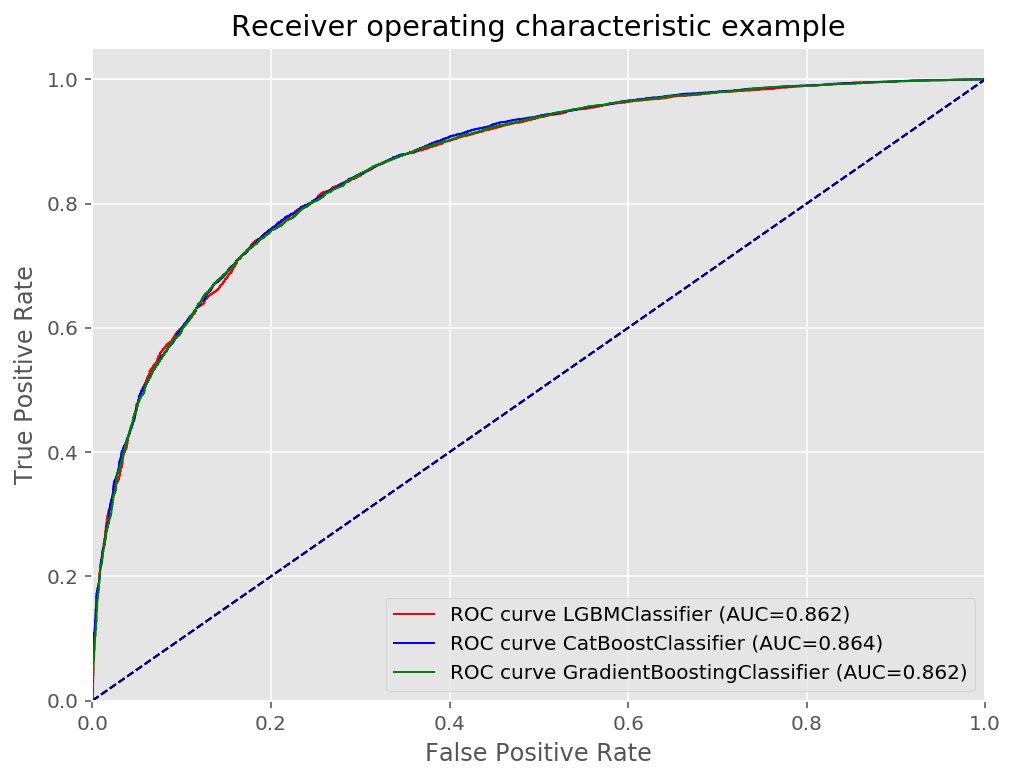

In [222]:
plt.figure(figsize=(8,6))
plot_roc(model1, X_validation_lgbm, y_validation, 'r')
plot_roc(model2, X_validation_cat, y_validation, 'b')
plot_roc(model3, X_validation_grad, y_validation, 'g')

### Feature importance
- LGBMClassifier

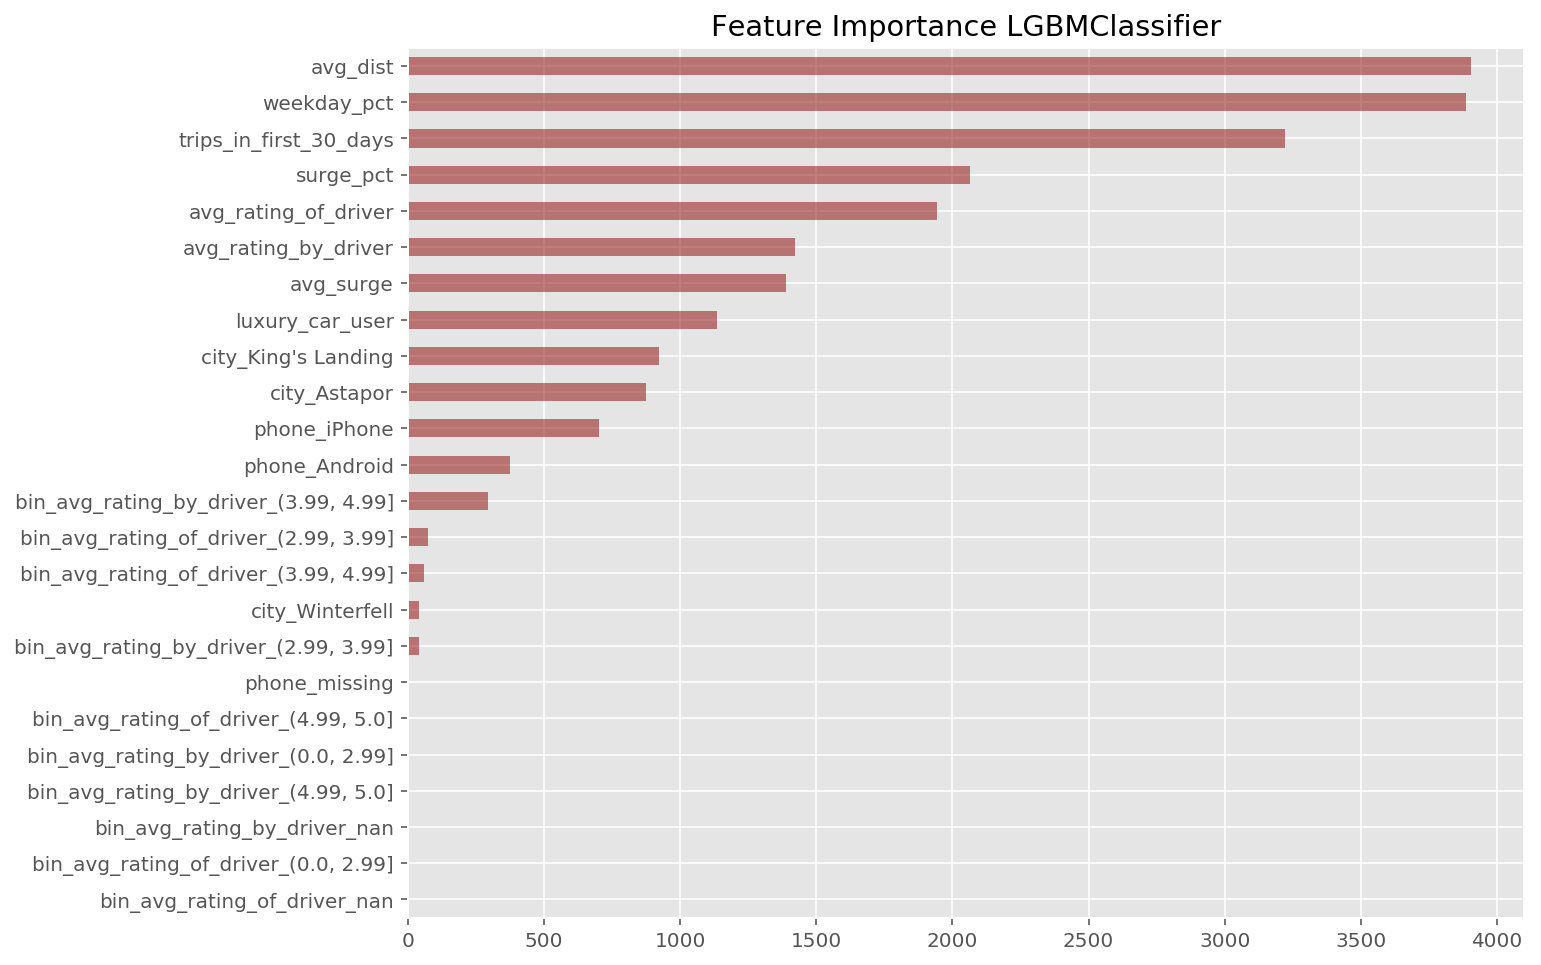

In [184]:
importance_series = pd.Series(data=model1.feature_importances_, index=X_validation_lgbm.columns)
ax = importance_series.sort_values().plot(kind='barh',width=0.5, figsize=(10,8), color='darkred', alpha=0.5)
ax.set_title('Feature Importance LGBMClassifier');

- CatBoostClassifier

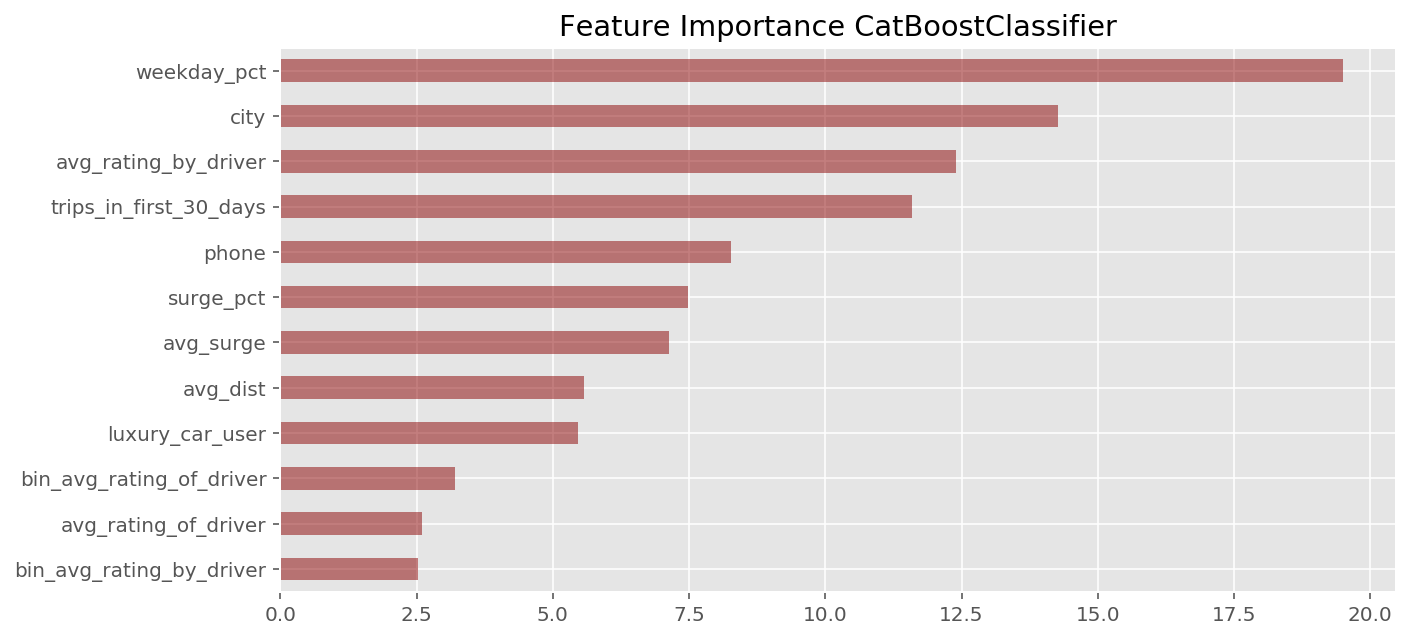

In [84]:
importance_series = pd.Series(data=model2.feature_importances_, index=X_validation_cat.columns)
ax = importance_series.sort_values().plot(kind='barh',width=0.5, figsize=(10,5), color='darkred', alpha=0.5)
ax.set_title('Feature Importance CatBoostClassifier');

In [85]:
pool1 = Pool(data=X_validation_cat, label=y_validation, cat_features=cat_features)
shap_info = model2.get_feature_importance(data=pool1, fstr_type='ShapValues', verbose=10000)
shap_values = shap_info[:,:-1]
base_values = shap_info[:,-1]
print(shap_values.shape)

The model has complex ctrs, so the SHAP values will be calculated approximately.
Processing trees...
128/340 trees processed	passed time: 178ms	remaining time: 295ms sec
340/340 trees processed	passed time: 533ms	remaining time: 0us sec
Processing documents...
128/12000 documents processed	passed time: 3.5ms	remaining time: 324ms sec
10112/12000 documents processed	passed time: 169ms	remaining time: 31.5ms sec
12000/12000 documents processed	passed time: 200ms	remaining time: 0us sec
(12000, 12)


### Feature interaction 

- Catboost feature interaction with the model output

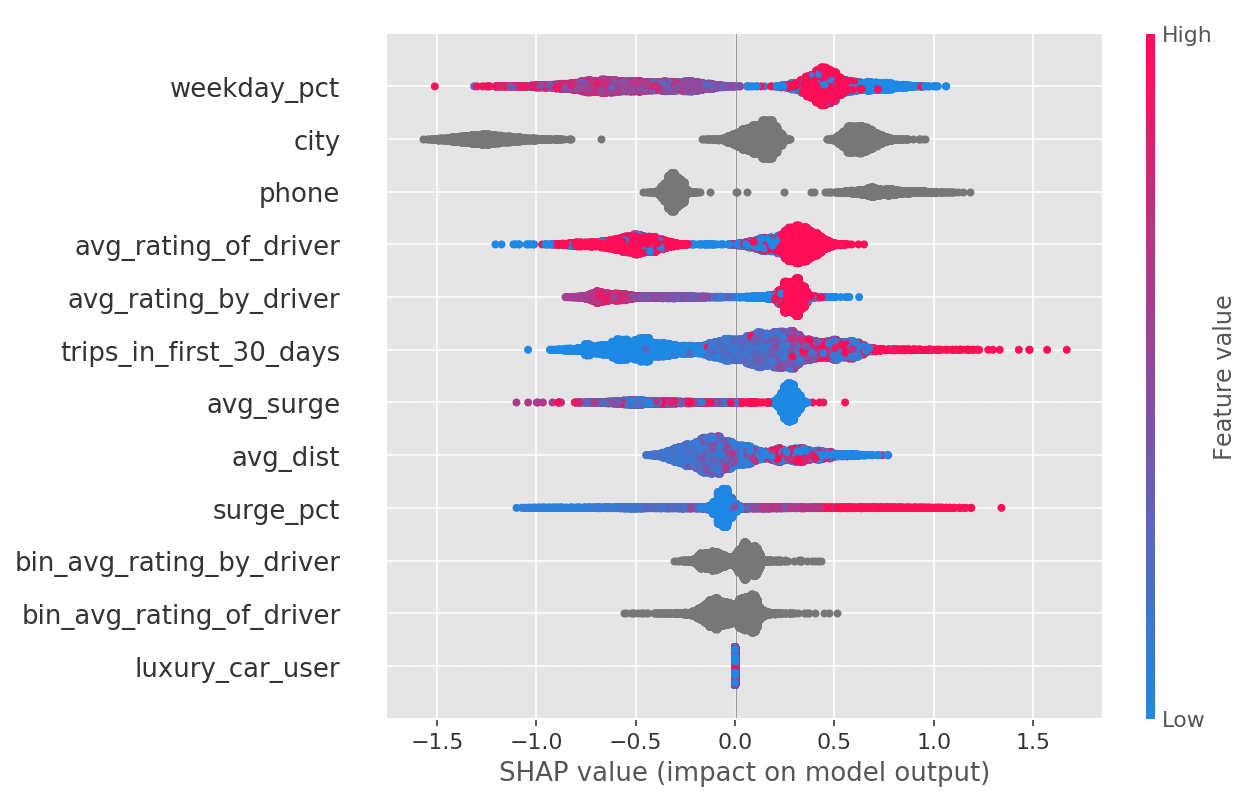

In [86]:
shap.summary_plot(shap_values, X_validation_cat)

- GradientBoosting feature interaction with the model output

In [196]:
names = ['avg_dist',
'weekday_pct',
'trips_in_first_30_days',
'surge_pct',
'avg_surge',
'avg_dist',
'luxury_car_user',
"city_King's Landing",
'city_Winterfell',
'city_Astapor',
'phone_iPhone',
'phone_Android'
'bin_avg_rating_of_driver',
'bin_avg_rating_by_driver']
feature_ind = np.where(X_train_grad.columns.isin(names))[0]

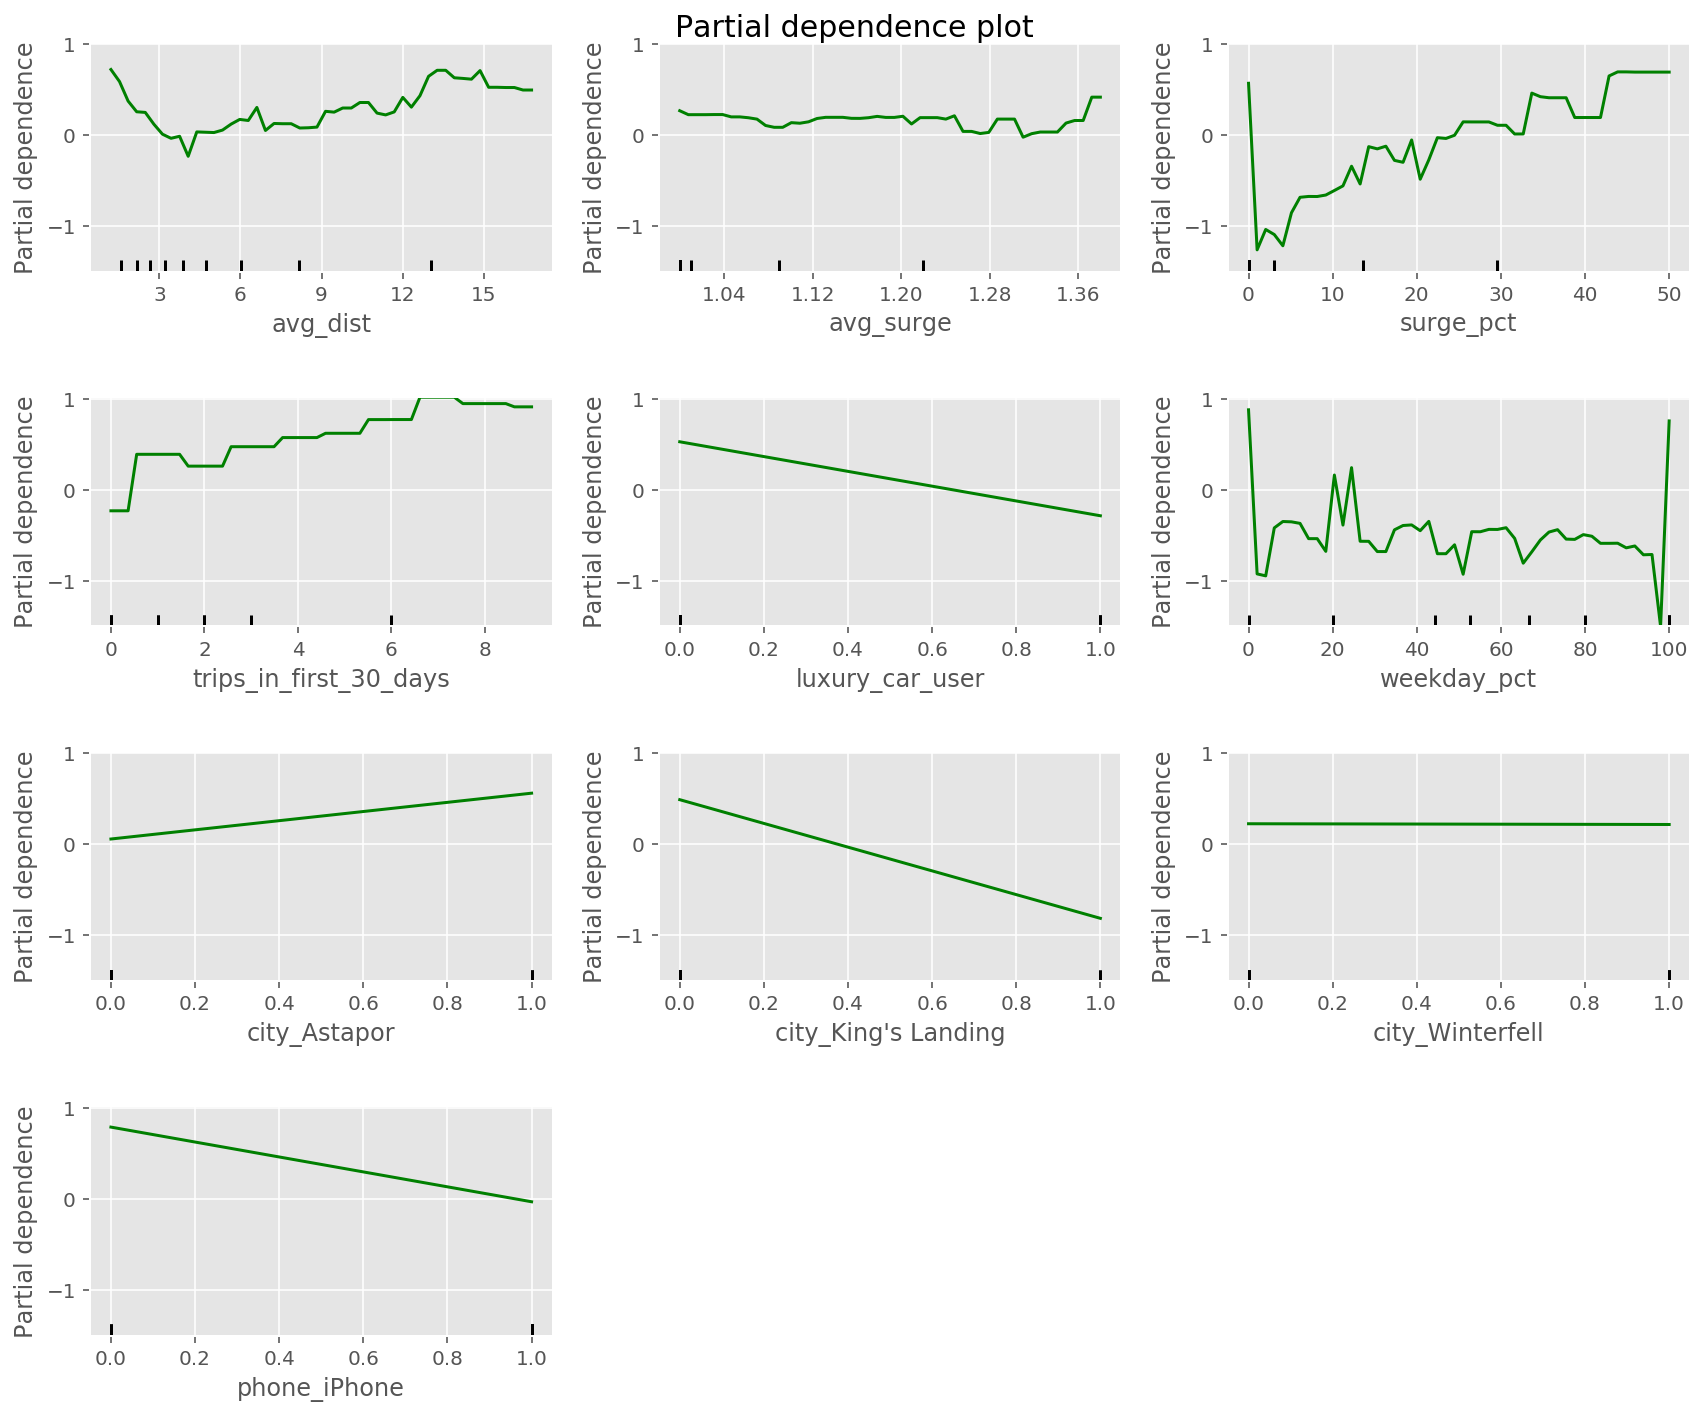

In [198]:
fig, axs = plot_partial_dependence(model3, X_train_grad.values, features=feature_ind,
                                       feature_names=X_train_grad.columns,
                                       n_jobs=3, grid_resolution=50)
fig.set_size_inches(12, 10)
plt.suptitle('Partial dependence plot',size=15);
plt.tight_layout()


### Object level analysis

If we want to understand why my model predicts such probability on the n-th object, we can checkout the shap value. Shap value is a unified approach to explain the output of any machine learning model. 

Sum of all shap values are equal to the resulting raw formula predition. We can see on the graph that will be output below that there is a base value, which is equal for all the objects. And most of the feature have negative influence on this object. The biggest step to the left (lower logodds i.e. lower probabilty of churn) is because of the feature called 'city'.

In [112]:
idx = 5
test_object = [X_validation_cat.iloc[idx]]
print(X_validation_cat.iloc[idx])
# for obj in test_objects:
logodds = model2.predict(test_object, prediction_type='RawFormulaVal')[0]
print('\n')
print('Probability of class 1 = {:.4f}'.format(model2.predict_proba(test_object)[0][1]))
print('Formula raw prediction/Log-odds = {:.4f}'.format(logodds))
odds = np.exp(logodds)
prob = odds / (1 + odds)
print('Probability converted:',prob)


shap.initjs()
shap.force_plot(base_value=base_values[idx], shap_values=shap_values[idx], features=X_validation_cat.iloc[idx])

avg_dist                              3.93
avg_rating_by_driver                     5
avg_rating_of_driver                     5
avg_surge                             1.13
city                        King's Landing
phone                               iPhone
surge_pct                             37.5
trips_in_first_30_days                   0
luxury_car_user                      False
weekday_pct                             50
bin_avg_rating_by_driver       (4.99, 5.0]
bin_avg_rating_of_driver       (4.99, 5.0]
Name: 36572, dtype: object


Probability of class 1 = 0.1662
Formula raw prediction/Log-odds = -1.6127
Probability converted: 0.166212868755


The raw prediction is not the probability, to calculate probability from raw prediction you need to calculate sigmoid(raw_prediction).

**Some interesting discoveries by the CatboostClassifier:**

- Signed up in King's Landing is the most important feature that makes the model think this user will not churn
- Contrary to the eyeball method, lower trips in first 30 days could be the reason for not churn.
- Surprisingly, very high avg rating of/by the driver such as 5.0 could lead to churn case.

# Part III User resurrection

**Since now we have a model which can predict churn probability for each user, we can do something to prevent user churn. My suggestion is to send some promotion code to those who are likely to churn based on predicted probability. Assumption being made is that if a user receives a promotion code, he/she will probably use the code and be 'resurrected', a resurrected user will bring some revenue in the future, but such campaign has some cost, such cost happens whenever the model predict churn based on certain threshold. How to find the sweet-spot to maximize company's revenue is the goal. Before we determine the sweet-spot/threshold that maximize the profit, we need to specify a cost-benefit matrix. Each cell of the matrix will correspond to the corresponding cost/benefit of the outcome of a correct or incorrect classification. It should contain the cost of true positives, false positives, true negatives and false negatives in the following form:**

```python
[[tp, fp]
 [fn, tn]]
```


<ul> Here's where we can use some intuition to place some values on the cost of trying to identify a customer as a potential churner, and the benefit of doing so correctly. Without scrutinizing these numbers too highly let's say that if we predict a customer as someone who is likely to churn in the near future we might want to incentivize them to remain active by sending them a $30 off coupon.


Now there are two options that could result from the campaign, they could stay a customer, in which case we continue to gain the profit associated with that, lets say it's \$100 for a customer LTV, but they could also just use the coupon and then churn anyways. Remember, either way we're spending \$30 with this plan. This leaves us with the following cost-benefit matrix:

```python
[[70, -30],
 [ 0,   0]]
```
We could fret over what happens when we don't predict that someone is going to churn and place values on the associated situations. But for now this cost-benefit matrix will do.

In [94]:
model_profits = []
cost_benefit = np.array([[70, -30], [0, 0]])

In [96]:
profits, thresholds = get_model_profits(model1, cost_benefit,
                                                X_validation_lgbm.values,
                                                y_validation.values)
model_profits.append((model1, profits, thresholds))
profits, thresholds = get_model_profits(model2, cost_benefit,
                                                X_validation_cat,
                                                y_validation.values)
model_profits.append((model2, profits, thresholds))
profits, thresholds = get_model_profits(model3, cost_benefit,
                                                X_validation_grad,
                                                y_validation.values)
model_profits.append((model3, profits, thresholds))

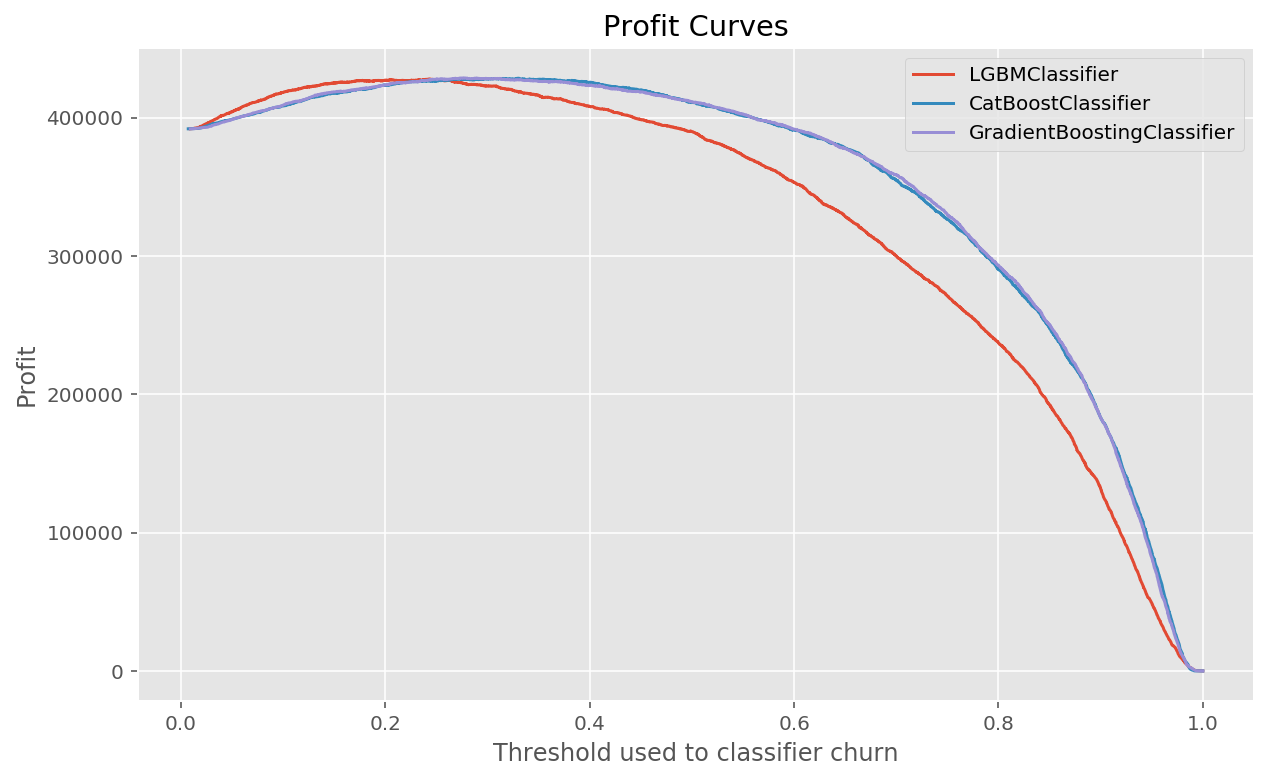

In [100]:
plt.figure(figsize=(10,6))
plot_model_profits(model_profits)

In [101]:
max_model, max_thresh, max_profit = find_best_threshold(model_profits)
if max_model.__class__.__name__ == 'CatBoostClassifier':
    max_labeled_positives = max_model.predict_proba(X_validation_cat) >= max_thresh
elif max_model.__class__.__name__ == 'LGBMClassifier':
    max_labeled_positives = max_model.predict_proba(X_validation_lgbm) >= max_thresh
else:
    max_labeled_positives = max_model.predict_proba(X_validation_grad) >= max_thresh
proportion_positives = max_labeled_positives.mean()
reporting_string = ('Best model:\t\t{}\n'
                    'Best threshold:\t\t{:.2f}\n'
                    'Resulting profit:\t{}\n'
                    'Proportion positives:\t{:.2f}')
print(reporting_string.format(max_model.__class__.__name__, max_thresh,
                              max_profit, proportion_positives))

Best model:		GradientBoostingClassifier
Best threshold:		0.28
Resulting profit:	428890
Proportion positives:	0.65


In our case, the best threshold found is 0.28, and maximal profit generated by such campaign is $428890.